In [2]:
import sys
sys.path.append("/home/rezecib/caffe/python")

In [3]:
import os, caffe, lmdb, cv2, subprocess
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from caffe import layers as L
from caffe import params as P
from caffe.proto import caffe_pb2
from IPython.display import Image as dImage
from IPython.display import display
import pandas as pd
import subprocess
caffe.set_mode_gpu()

def showImages(*args):
    imgs = (dImage(filename=arg) for arg in args)
    display(*imgs)

In [5]:
def make_datum(img):
    return caffe_pb2.Datum( channels = 1,
                            width    = img.shape[1],
                            height   = img.shape[0],
                            data     = img[np.newaxis, ...].tostring())

imagefolder = os.path.join("Zebrafish_BB", "Images")
boboxfolder = os.path.join("Zebrafish_BB", "BB")
imagefiles = os.listdir(imagefolder)
output_shape = (634, 474) #This should be calculated from the network architecture...

#Determine how to store the label
# label_style = "bounding_box" #-> store an image that's black, but white inside the bounding box
label_style = "box_fish"     #-> store an image that's white where the fish is, within the box

lmdb_dir = os.path.join(".", "lmdb" if label_style == "box_fish" else "lmdb_bb")

train_x_lmdb = os.path.join(lmdb_dir, "train_x")
train_y_lmdb = os.path.join(lmdb_dir, "train_y")
test_x_lmdb = os.path.join(lmdb_dir, "test_x")
test_y_lmdb = os.path.join(lmdb_dir, "test_y")


#Whether we should generate the lmdb on this pass
generate_lmdb = False #False if we already made it

in_idx = 0
if generate_lmdb:
    with lmdb.open(train_x_lmdb, map_size=int(1e9)) as train_x_db, lmdb.open(train_y_lmdb, map_size=int(1e9)) as train_y_db, \
    lmdb.open(test_x_lmdb, map_size=int(1e9)) as test_x_db, lmdb.open(test_y_lmdb, map_size=int(1e9)) as test_y_db, \
    train_x_db.begin(write=True) as trx_txn, train_y_db.begin(write=True) as try_txn, \
    test_x_db.begin(write=True) as tsx_txn, test_y_db.begin(write=True) as tsy_txn:
        for imagefile in imagefiles:
            img_arr = cv2.imread(os.path.join(imagefolder,imagefile), cv2.IMREAD_GRAYSCALE)
            lbl_arr = np.zeros_like(img_arr)
            
            bb = None
            boboxfile = imagefile[:-5] + ".txt"
            with open(os.path.join(boboxfolder,boboxfile)) as f:
                bb = np.array(f.read().split("\n")[1].split(), dtype=np.int_)
            
            if label_style == "box_fish":
                img_box = img_arr[bb[1]:bb[3], bb[0]:bb[2]]
                img_box = cv2.equalizeHist(img_box)
                #a threshold of 48 was chosen empirically, it seems to give good segmentation
                lbl_arr[bb[1]:bb[3], bb[0]:bb[2]] = 255*(img_box < 48)
            elif label_style == "bounding_box":
                lbl_arr[bb[1]:bb[3], bb[0]:bb[2]] = 255
                #back when I had to rescale... keeping for reference in case I go back?
                #np.array(Image.fromarray(target_img_arr).resize(output_shape, Image.ANTIALIAS))

            #src_arr is just to output the diagnostic image below; lbl_arr is our label
#             src_arr = np.array(Image.fromarray(img_arr).resize(output_shape, Image.ANTIALIAS))
#             plt.imshow(np.minimum(img_arr, lbl_arr), cmap="gray")
#             box_arr = np.zeros((480, 640, 3), dtype=img_arr.dtype)
#             box_arr += img_arr[..., np.newaxis].copy()
#             red = np.array([[[255, 0, 0]]], dtype=img_arr.dtype)
#             box_arr[bb[1]:bb[3], bb[0]-2:bb[0]+1] = red
#             box_arr[bb[1]:bb[3], bb[2]-1:bb[2]+2] = red
#             box_arr[bb[1]-2:bb[1]+1, bb[0]-2:bb[2]+2] = red
#             box_arr[bb[3]-1:bb[3]+2, bb[0]-2:bb[2]+2] = red
#             plt.imshow(box_arr)
#             plt.imshow(img_box, cmap="gray")
#             plt.show()

            x_txn = tsx_txn if in_idx % 6 == 0 else trx_txn
            y_txn = tsy_txn if in_idx % 6 == 0 else try_txn
            x_txn.put('{:0>5d}'.format(in_idx), make_datum(img_arr).SerializeToString())
            y_txn.put('{:0>5d}'.format(in_idx), make_datum(lbl_arr).SerializeToString())
            in_idx += 1
    print "Data cases:", in_idx

307200 1.0


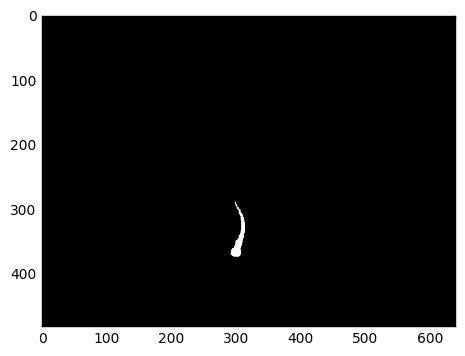

In [4]:
#"""
label = True
db = train_y_lmdb if label else train_x_lmdb
rshw = 640#634 if label else 640
rshh = 480#474 if label else 480
with lmdb.open(db, readonly=True) as x_db, x_db.begin() as txn:
    raw_datum = txn.get("00002")
    datum = caffe_pb2.Datum()
    datum.ParseFromString(raw_datum)
    flat_x = np.fromstring(datum.data, dtype=np.uint8)
    print flat_x.shape[0], float(flat_x.shape[0])/(rshw*rshh)
    x = flat_x.reshape(1, rshh, rshw)
    plt.imshow(x[0], cmap="gray")
    plt.show()
#     arr = np.array(Image.open(Image.io.BytesIO(datum.data)))
#     print arr
#     plt.imshow(arr, cmap="gray")
#     plt.show()
#"""
pass

Drawing net to net_train.png
Drawing net to net_test.png


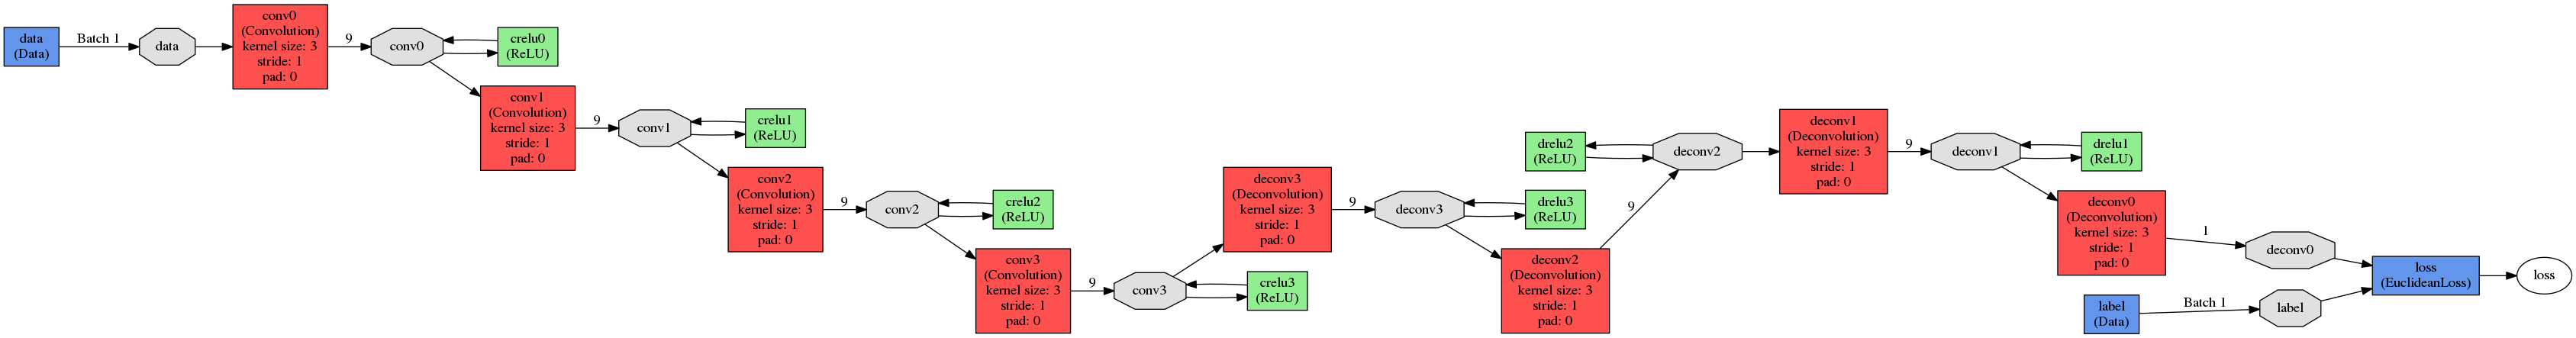

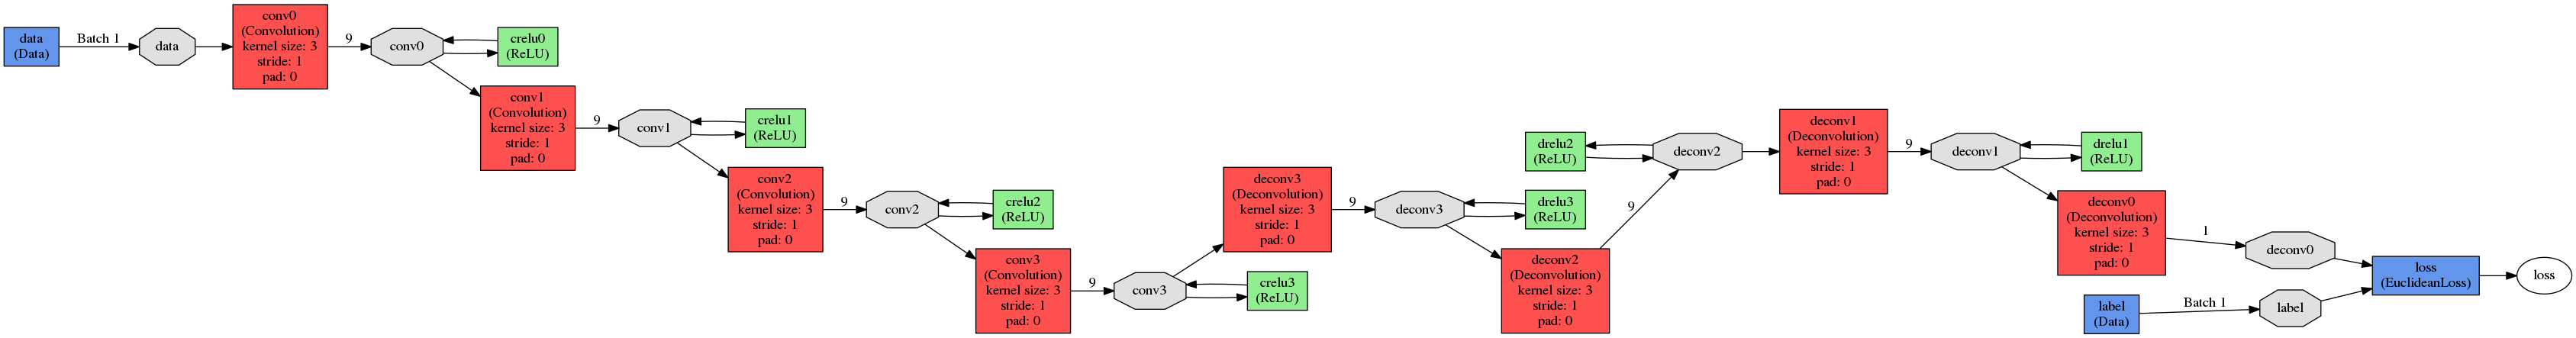

Networks created


In [6]:
batch_size = 1
#My memory capacity seems to be between 63 and 70 copies of the image (for the conv layers)
# so ((num_conv_layers * 2) - 1)*num_filters should be in this range
num_filters = 9
filter_size = 3
num_conv_layers = 4
xav = dict(type="xavier")
#can't batch norm because the GPU memory only supports a batch size of 1
# bn_param = [dict(lr_mult=0, decay_mult=0), dict(lr_mult=0, decay_mult=0), dict(lr_mult=0, decay_mult=0)]

relu = True
#for leaky relu, negative_slope=0.01
neg_slo = 0.01

#If we use pooling, we have to set the padding to preserve image size so that the dimensions stay divisible by 2
# this also means no deconvolutional layers to restore image size
pool = False
pool_freq = 2
pooling_param = dict(kernel_size=2, stride=2)
unpooling_param = dict(kernel_size=2, stride=2, num_output=num_filters)

pad = (filter_size - 1)/2 if pool else 0 #preserve size of input through convolution
convolution_param = dict(kernel_size=filter_size, num_output=num_filters, pad=pad, weight_filler=xav)

n = None #the network we're currently building
prevL = None #the previous layer added
prevName = None
def addLayer(name, layer):
    global prevL, prevName
    prevL = layer
    prevName = name
    setattr(n, name, layer)
    return layer

def buildNet(train=True):
    global n
    n = caffe.NetSpec()
    addLayer("data", L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=(train_x_lmdb if train else test_x_lmdb)))
    for i in xrange(1,num_conv_layers+1):
        addLayer("conv%d"%(i-1), L.Convolution(prevL, convolution_param=convolution_param))
        if relu:
            addLayer("crelu%d"%(i-1), L.ReLU(prevL, in_place=True, negative_slope=neg_slo))
        if pool and i%pool_freq == 0:
            addLayer("pool%d"%i, L.Pooling(prevL, pooling_param=pooling_param))
    for i in reversed(xrange(1,num_conv_layers+1)):
        if pool:
            if i%pool_freq == 0:
                addLayer("unpool%d"%i, L.Deconvolution(prevL, convolution_param=unpooling_param))
        outputs = 1 if i == 1 else num_filters
        addLayer("deconv%d"%(i-1), L.Deconvolution(prevL,
            convolution_param=dict(kernel_size=filter_size, num_output=outputs, pad=pad, weight_filler=xav)))
        if relu and i != 1:# and (not pool or i%pool_freq == 0): #the last one seems to mess things up
            addLayer("drelu%d"%(i-1), L.ReLU(prevL, in_place=True, negative_slope=neg_slo))
    if pool: #add one deconv layer at the end to convert to one-dimensional pixels
        addLayer("deconv", L.Deconvolution(prevL,
                 convolution_param=dict(kernel_size=filter_size, num_output=1, pad=pad, weight_filler=xav)))
    #don't use addLayer for these ones because they branch
    n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=(train_y_lmdb if train else test_y_lmdb))
    n.loss  = L.EuclideanLoss(prevL, n.label)
    return n

with open("net_train.prototxt", "w") as f:
    f.write(str(buildNet().to_proto()))
with open("net_test.prototxt", "w") as f:
    f.write(str(buildNet(False).to_proto()))

!python ~/caffe/python/draw_net.py net_train.prototxt net_train.png
!python ~/caffe/python/draw_net.py net_test.prototxt net_test.png
showImages("net_train.png", "net_test.png")
print("Networks created")

In [6]:
#It doesn't close the lmdb properly, so wrap it in its own kernel so that when the kernel exits, it gets closed
# !python run_solver.py
print "Solving..."
_ = !~/caffe/build/tools/caffe train --solver solver.prototxt 2>&1 | tee solver.log
print "Done!"
# solver = caffe.get_solver("solver.prototxt")
# solver.solve()

Solving...
Done!


      #Iters       Seconds  TrainingLoss  LearningRate
0          0     18.337687    17737000.0       0.00001
1        113     61.268158    21879400.0       0.00001
2        226    104.195853    21695200.0       0.00001
3        339    147.130859    15852800.0       0.00001
4        452    190.063379    11387200.0       0.00001
5        565    233.568475    20637500.0       0.00001
6        678    276.510546    24692200.0       0.00001
7        791    319.459114    35857300.0       0.00001
8        904    362.409919    26912000.0       0.00001
9       1017    423.626929    26321200.0       0.00001
10      1130    466.573274    29740100.0       0.00001
11      1243    509.525565    17310500.0       0.00001
12      1356    552.469995    25092500.0       0.00001
13      1469    595.414855    16896500.0       0.00001
14      1582    638.356387    11612400.0       0.00001
15      1695    681.555503    23150300.0       0.00001
16      1808    724.782614    19324200.0       0.00001
17      19

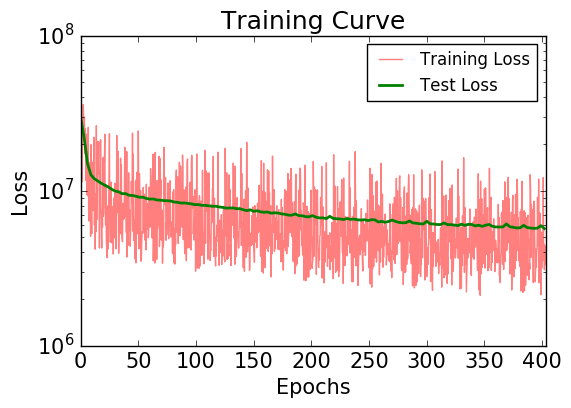

0

In [41]:
### Adapted from https://github.com/adilmoujahid/deeplearning-cats-dogs-tutorial/blob/master/code/plot_learning_curve.py
### Plot learning curve
command = "~/caffe/tools/extra/parse_log.sh solver.log"
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
process.wait()
train_log = pd.read_csv("solver.log.train", delim_whitespace=True)
test_log = pd.read_csv("solver.log.test", delim_whitespace=True)

print train_log
print test_log

fig, ax = plt.subplots()

print(type(train_log['#Iters'][0]))
print(train_log['#Iters'][0])

#Plotting training and test losses
train_loss, = ax.plot(np.array(train_log['#Iters'])*(1.0/339), train_log['TrainingLoss'], color='red',  alpha=.5)
# for some reason it puts the test loss under the Accuracy column
test_loss, = ax.plot(np.array(test_log['#Iters'])*(1.0/339), test_log['TestAccuracy'], linewidth=2, color='green')
# ax1.set_ylim(ymin=0, ymax=1)
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_yscale('log')
ax.set_xlim(xmin=0, xmax=np.array(train_log['#Iters'])[-1]*(1.0/339))
ax.tick_params(labelsize=15)
#Adding legend
plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'])#,  bbox_to_anchor=(1, 0.8))
plt.title('Training Curve', fontsize=18)
#Saving learning curve
plt.show()

'''
Deleting training and test logs
'''
command = 'rm ' + "solver.log.train"
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
process.wait()

command = command = 'rm ' + "solver.log.test"
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
process.wait()

In [7]:
solver = None
net = None

Outlbl range: 0.0 223.791
Input range:  0.0 230.0
Output range: -212.128 42.4406
Labels range: 0.0 255.0


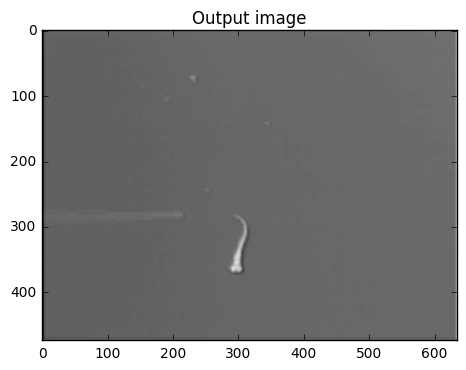

In [13]:
### Visualize the output
if solver is None:
    solver = caffe.get_solver("solver.prototxt")
    snapshots = os.listdir("snapshot")
    max_snapshot_iter = 0
    max_snapshot = ""
    for snapshot in snapshots:
        if snapshot[-12:] == ".solverstate":
            snapshot_iter = int(snapshot[11:-12])
            if max_snapshot_iter < snapshot_iter:
                max_snapshot_iter = snapshot_iter
                max_snapshot = snapshot
    solver.restore(os.path.join("snapshot", max_snapshot))
    net = solver.test_nets[0]
#     for _ in xrange(6): #skip to a good diagnostic image with finger + probe + good fish
#         net.forward()
# net.forward()
batch_size = net.blobs['data'].num
# print net.blobs['data'].data[0,0]
# print net.blobs['data'].data.shape
# print net.blobs['data'].data[0,0].sum()
# print net.blobs['label'].data[0,0].sum()
#  +      "plt.imshow(net.deprocess('data', net.blobs['data'].data[4]))" 
# plt.imshow(solver.test_nets[0].blobs['label'].data[0,0]*solver.test_nets[0].blobs['conv3'].data[0,0], cmap="gray")
# plt.imshow(net.blobs['data'].data[0,0], cmap="gray")
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
# output = transformer.deprocess('data', net.blobs[prevName].data[0])
output = transformer.deprocess('data', net.blobs['deconv0'].data[0])
# origin = np.array(Image.fromarray(transformer.deprocess('data', net.blobs['data'].data[0])).resize(output_shape, Image.ANTIALIAS))
origin = transformer.deprocess('data', net.blobs['data'].data[0])
labels = transformer.deprocess('data', net.blobs['label'].data[0])
outlbl = output - output.min() #scale min to zero
outlbl *= 255/outlbl.max() #scale max to 255
outlbl = np.minimum(origin, outlbl) #use it as a mask over the input
print "Outlbl range:", outlbl.min(), outlbl.max()
#The edges get messed up...
p = 3
output = output[p:-p,p:-p]
print "Input range: ", origin.min(), origin.max()
print "Output range:", output.min(), output.max()
print "Labels range:", labels.min(), labels.max()
# plt.imshow(np.minimum(np.maximum(output, 0), origin), cmap="gray")
from pylab import rcParams
# rcParams['figure.figsize'] = 6*1.9, 4*1.9
# plt.subplot(221)
# plt.title("Input image")
# plt.imshow(origin.astype(np.float_)*((labels.astype(np.float_) + 255) * 0.5), cmap="gray")
# plt.imshow(origin, cmap="gray")
# plt.subplot(222)
# plt.title("Label image")
# plt.imshow(labels, cmap="gray")
# plt.subplot(223)
# plt.title("Input with output image mask")
# plt.imshow(outlbl, cmap="gray")
# plt.subplot(224)
plt.title("Output image")
plt.imshow(output, cmap="gray")
plt.show()
rcParams['figure.figsize'] = 6, 4 #in case I go back and run the cells above